In [63]:
import pandas as pd
import numpy as np
import re
from collections import Counter
import random
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
# imports to visualize tree
from sklearn import tree as treeViz
import graphviz
from IPython.display import display

In [64]:
STOP_WORDS = {'call', 'upon', 'still', 'nevertheless', 'down', 'every', 'forty', 're', 'always', 'whole', 'side', "n't",
              'now', 'however', 'an', 'show', 'least', 'give', 'below', 'did', 'sometimes', 'which', "'s", 'nowhere', 'per',
              'hereupon', 'yours', 'she', 'moreover', 'eight', 'somewhere', 'within', 'whereby', 'few', 'has', 'so', 'have',
              'for', 'noone', 'top', 'were', 'those', 'thence', 'eleven', 'after', 'no', 'll', 'others', 'ourselves', 'themselves',
              'though', 'that', 'nor', 'just', 's', 'before', 'had', 'toward', 'another', 'should', 'herself', 'and', 'these',
              'such', 'elsewhere', 'further', 'next', 'indeed', 'bottom', 'anyone', 'his', 'each', 'then', 'both', 'became',
              'third', 'whom', 've', 'mine', 'take', 'many', 'anywhere', 'to', 'well', 'thereafter', 'besides', 'almost',
              'front', 'fifteen', 'towards', 'none', 'be', 'herein', 'two', 'using', 'whatever', 'please', 'perhaps', 'full',
              'ca', 'we', 'latterly', 'here', 'therefore', 'how', 'was', 'made', 'the', 'or', 'may', 're', 'namely',
              "'ve", 'anyway', 'amongst', 'used', 'ever', 'of', 'there', 'than', 'why', 'really', 'whither', 'in', 'only',
              'wherein', 'last', 'under', 'own', 'therein', 'go', 'seems', 'm', 'wherever', 'either', 'someone', 'up',
              'doing', 'on', 'rather', 'ours', 'again', 'same', 'over', 's', 'latter', 'during', 'done', "'re", 'put',
              "'m", 'much', 'neither', 'among', 'seemed', 'into', 'once', 'my', 'otherwise', 'part', 'everywhere', 'never',
              'myself', 'must', 'will', 'am', 'can', 'else', 'although', 'as', 'beyond', 'are', 'too', 'becomes', 'does', 'a',
              'everyone', 'but', 'some', 'regarding', 'll', 'against', 'throughout', 'yourselves', 'him', "'d", 'it', 'himself',
              'whether', 'move', 'm', 'hereafter', 're', 'while', 'whoever', 'your', 'first', 'amount', 'twelve', 'serious',
              'other', 'any', 'off', 'seeming', 'four', 'itself', 'nothing', 'beforehand', 'make', 'out', 'very', 'already',
              'various', 'until', 'hers', 'they', 'not', 'them', 'where', 'would', 'since', 'everything', 'at', 'together',
              'yet', 'more', 'six', 'back', 'with', 'thereupon', 'becoming', 'around', 'due', 'keep', 'somehow', 'nt', 'across',
              'all', 'when', 'i', 'empty', 'nine', 'five', 'get', 'see', 'been', 'name', 'between', 'hence', 'ten', 'several', 'from',
              'whereupon', 'through', 'hereby', "'ll", 'alone', 'something', 'formerly', 'without', 'above', 'onto', 'except', 'enough',
              'become', 'behind', 'd', 'its', 'most', 'nt', 'might', 'whereas', 'anything', 'if', 'her', 'via', 'fifty', 'is',
              'thereby', 'twenty', 'often', 'whereafter', 'their', 'also', 'anyhow', 'cannot', 'our', 'could', 'because', 'who',
              'beside', 'by', 'whence', 'being', 'meanwhile', 'this', 'afterwards', 'whenever', 'mostly', 'what', 'one', 'nobody',
              'seem', 'less', 'do', 'd', 'say', 'thus', 'unless', 'along', 'yourself', 'former', 'thru', 'he', 'hundred', 'three',
              'sixty', 'me', 'sometime', 'whose', 'you', 'quite', 've', 'about', 'even'}

In [65]:
def replace_nan(df, column_means):
  columns_to_replace = ['Q1', 'Q2', 'Q3', 'Q4', 'Q7', 'Q8', 'Q9']

  for index, row in df.iterrows():
    for col in columns_to_replace:
      if pd.isnull(row[col]):
        df.at[index, col] = int(column_means[col])

  return df



In [66]:
def organize_data(df):
  df["Q5"] = df["Q5"].fillna('')
  df["Q6"] = df["Q6"].fillna('')
  df["Q10"] = df["Q10"].fillna('')

  # Convert Q5 categories into binary features
  q5_categories = ["Partner", "Friends", "Siblings", "Co-worker"]
  for category in q5_categories:
    df[f"Q5_{category}"] = df["Q5"].apply(lambda s: 1 if category in s else 0)

  # Convert Q6 categories into binary features
  q6_categories = ["Skyscrapers", "Sport", "Art and Music", "Carnival", "Cuisine", "Economic"]
  for category in q6_categories:
    numbers = [int(re.findall(f"{category}=>(\d+)", s)[0]) if re.findall(f"{category}=>(\d+)", s) else 0 for s in
                df["Q6"]]
    df[f"Q6_{category}"] = numbers

  # Drop original columns
  df.drop(["Q5", "Q6"], axis=1, inplace=True)

  # fix string values input to Q7 and Q9
  df['Q7'] = pd.to_numeric(df['Q7'].str.replace(',', ''), errors='coerce')
  df['Q9'] = pd.to_numeric(df['Q9'].str.replace(',', ''), errors='coerce')

  df["Q10"] = df["Q10"].astype(str)
  df["Q10"] = df["Q10"].apply(lambda s: re.sub(r'[^a-zA-Z\s]', ' ', s))
  df["Q10"] = df["Q10"].apply(lambda s: ' '.join(s.split()))

  vocab_list = list()
  for text in df["Q10"]:
    words = text.split()
    vocab_list.extend(words)
  vocab_list = list(set(word.lower() for word in vocab_list))

  filtered_vocab_list = [word for word in vocab_list if word.lower() not in STOP_WORDS]

  for word in filtered_vocab_list:
    df[word] = df["Q10"].apply(lambda x: Counter(x.split())[word])

  column_means = df[["Q1", "Q2", "Q3", "Q7", "Q8", "Q9", "Q4"]].mean().astype(int)
  df = replace_nan(df, column_means)
  df.drop(["Q10"], axis=1, inplace=True)

  return df

In [67]:
from google.colab import files
uploaded = files.upload()

Saving clean_dataset.csv to clean_dataset (4).csv


In [ ]:
filename = next(iter(uploaded))
df = pd.read_csv(filename)
df = organize_data(df)
df = df.drop(["id"], axis=1)

t = df["Label"]
X = df.drop(["Label"], axis=1)

X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.2,
                                                    random_state=21)
X_train, X_valid, t_train, t_valid = train_test_split(X_train, t_train,
                                                      test_size=0.2,
                                                      random_state=21)

panda shape:  Index(['Q1', 'Q2', 'Q3', 'Q4', 'Q7', 'Q8', 'Q9', 'Q5_Partner', 'Q5_Friends',
       'Q5_Siblings',
       ...
       'finance', 'fromage', 'natural', 'unconditionally', 'pursuit', 'arts',
       'delicate', 'janeiro', 'rude', 'despite'],
      dtype='object', length=1424)
accuracy with ('entropy', 5, 2): for testing: 0.8333333333333334


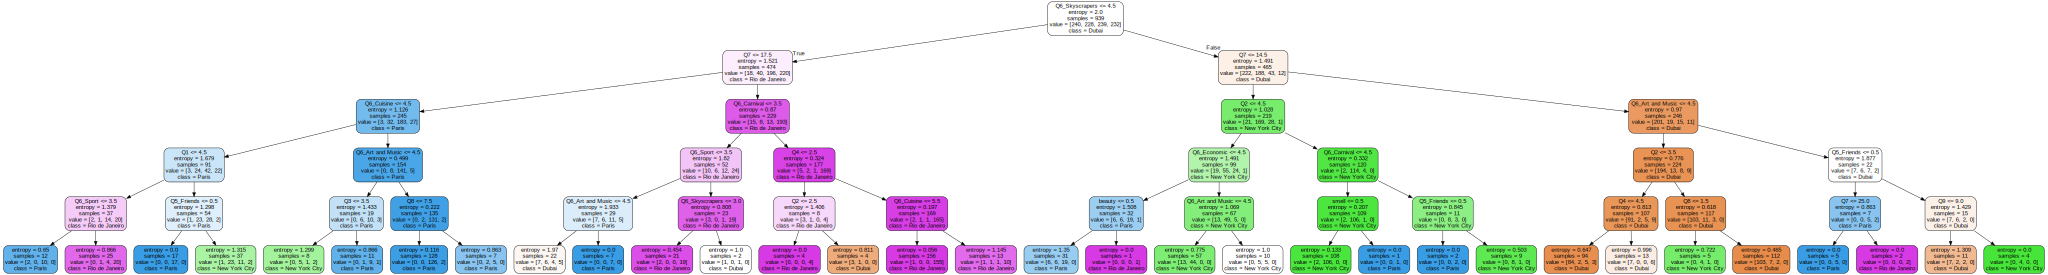

In [75]:
X_train, t_train, X_test, t_test, X
df = X
X = X_train
t = t_train
keys_array = df.keys()
print("panda shape:  " + str(df.keys()))

tree = DecisionTreeClassifier(criterion='entropy', max_depth=5,
                              min_samples_split=2,
                              random_state=1)
tree.fit(X, t)
accuracy_test = tree.score(X_test, t_test)
print(
    f"accuracy with ('entropy', 5, 2): for testing: {accuracy_test}")
keys_list = keys_array.tolist()

dot_data = treeViz.export_graphviz(tree,
                                    feature_names=keys_list,
                                    max_depth=5,
                                    class_names=["Dubai", "New York City",  "Paris", "Rio de Janeiro"],
                                    filled=True,
                                    rounded=True)

graph = graphviz.Source(dot_data)
display(graph)
# graph.render("decision_tree", format='png')  # Save the graph to a file
# files.download("decision_tree.png")  # Download the saved file

In [76]:
def generateSets(df):
    t = df["Label"]
    X = df.drop(["Label"], axis=1)

    X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.2)
    X_train, X_valid, t_train, t_valid = train_test_split(X_train, t_train,
                                                          test_size=0.2)
    return X_train, t_train, X_valid, t_valid, X_test, t_test

In [ ]:
totalAccuracies = 0
df = pd.read_csv(filename)
df = organize_data(df)
columns_with_nan = df.columns[df.isna().any()].tolist()

for i in range(100):
  X_train, t_train, X_valid, t_valid, X_test, t_test = generateSets(df)
  X = X_train
  t = t_train

  tree = DecisionTreeClassifier(criterion='entropy', max_depth=5,
                                min_samples_split=2)
  tree.fit(X, t)
  accuracy_test = tree.score(X_test, t_test)
  totalAccuracies += accuracy_test
avgAccuracy = totalAccuracies / 100
print(f"accuracy with ('entropy', 5, 2): for testing: {avgAccuracy}")

